In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

lidar_import = np.load('data/lidar_data.npz')
intensity = lidar_import['intensity']
dem = lidar_import['dem']
dsm = lidar_import['dsm']
shadow = lidar_import['shadow']

### Lidar Data Overview ###

Several lidar derivatives have previously been generated and are loaded above. These include:

* Intensity Raster: grayscale image derived from the pixel-wise average magnitude of lidar intensity returned.
* Bare Earth DEM: surface model of topography derived from lidar points previously classified as terrain
* First Return DSM: surface model of the highest lidar point per pixel
* Estimated Shadow Raster: locations of expected shadows at time of image collection; built from lidar DSM

Several pre-processing steps were applied to the lidar data to generate these data sets. Notable, the cars in the parking lot were excluded from the shadow map generation, as the variance in refelectance present in those regions were not conducive to this experiment.

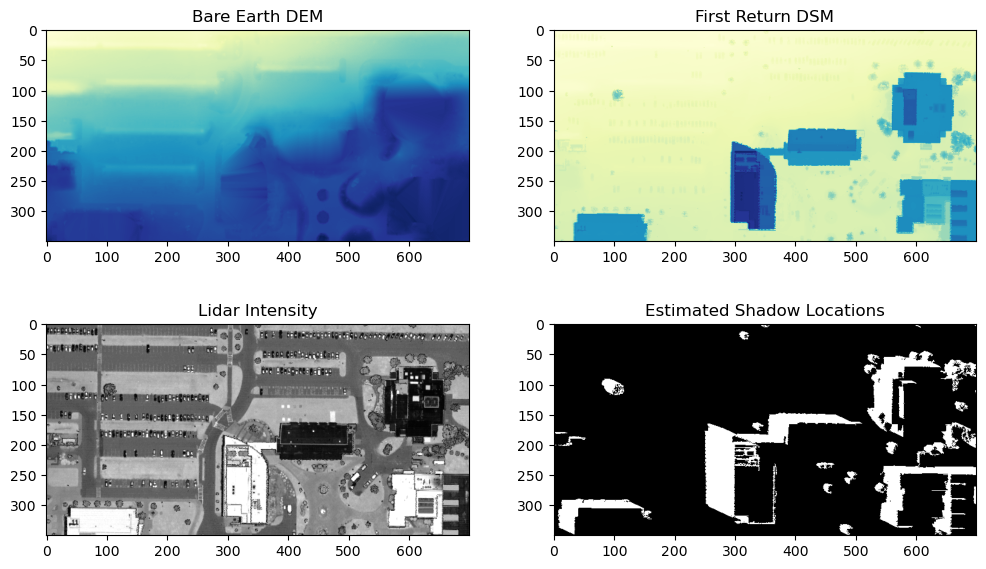

In [36]:
plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(dem, cmap='YlGnBu')
plt.title('Bare Earth DEM')


plt.subplot(222)
plt.imshow(dsm, cmap='YlGnBu')
plt.title('First Return DSM')

plt.subplot(223)
plt.imshow(intensity, cmap='gray')
plt.title('Lidar Intensity')

plt.subplot(224)
plt.imshow(shadow, cmap='gray')
plt.title('Estimated Shadow Locations')

plt.show()

### Initial Segmentation ###

We want to use the lidar data to identify regions which are likely homogenous surfaces. As lidar is an active form of remote sensing, intensity values tend to be very similar for returns coming from surfaces of a similar material and orientation. Using an unsupervised classification method suchh as k-Means clustering we can identify candidate regions for analysis. Later stages will identify distinct regions, so the number of initial clusters used in this step can be relatively small ($<10$). 

In general a smaller number of initial clusters allows for reasonable variation in lidar intensity to remain grouped together -- this step may need to be fine tuned depending on the intensity resolution of the sensor utilized, and the size of the area being processed.

As our focus is processing imagery at the ground level that has been obscured by shadows. We can threshold a normalized DSM to generate a mask that removes the tops of trees, cars, and buildings from our results.

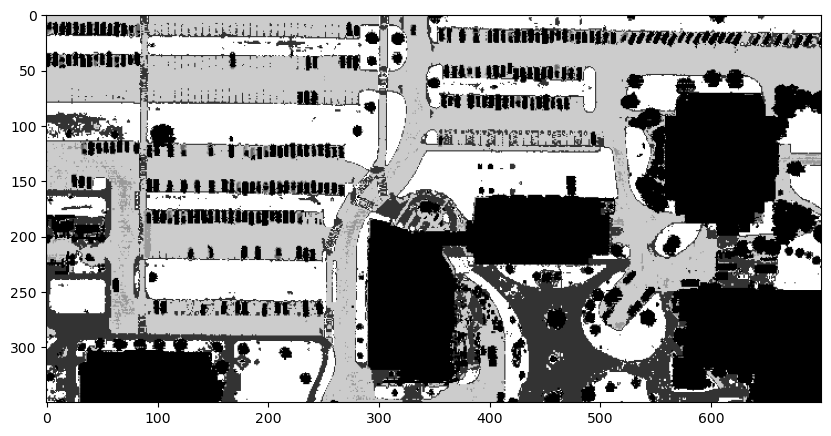

In [37]:
intensity_matrix = np.float32(intensity.reshape(intensity.shape[0] * intensity.shape[1]))
crit = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

val, segments, centers = cv.kmeans(intensity_matrix, 6, None, crit, 10, cv.KMEANS_RANDOM_CENTERS)
segments = segments.reshape(intensity.shape).astype(np.int32)

ndsm = dsm - dem
ndsm_mask = ndsm < 0.35    # height threshold in meters

plt.figure(figsize=(10,10))
plt.imshow(segments * ndsm_mask, cmap='gray')
plt.show()


### Regional Segmentation ###

The initial application of clustering based on lidar intensity values essentially groups together pixels within specific intensity ranges. While this serves as an initial proxy for surfaces of the same type, we need to build our training data from portions of surface that are comprised of the same material in roughly the same geometric conditions. This will require refining our segmentation such that we can work with localized patches of surface.

To that end, we apply a number of techniques from image processing. In order to determine the areas we can extract training data from, we will  
* Apply erosion to the initial segmentation to minimize pixelated noise
* Find 'connected componenets' - regions of the image in the same initial cluster that are distinct spatial regions
* Identify connected regions with pixels in both the shade and the open

In [38]:
def erode_segmented_image( boolean_image, mask, kernel_size ):
        
    erosion_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    eroded_img = cv.erode(np.uint8(boolean_image), erosion_kernel)
    return eroded_img * mask


In [39]:
def distinct_segment_regions( segment_map, min_area_in_pixels ):
    
    num_features, features, stats, centroids = cv.connectedComponentsWithStats(segment_map)
    connected_regions_to_use = {}
    current_idx = 0

    # identify connected regions with an area > minimum specified, and store a new region label
    # in dictionar for use in output (new labels are 0-based, sequential, only for features kept)

    for feature_label in range(1, num_features):
        if stats[feature_label, 4] >= min_area_in_pixels:
            connected_regions_to_use[feature_label] = current_idx
            current_idx += 1

    output_map = np.zeros_like(segment_map)
    for r in range(output_map.shape[0]):
        for c in range(output_map.shape[1]):
            if features[r,c] in connected_regions_to_use:
                output_map[r,c] = connected_regions_to_use[features[r,c]]

    return output_map

In [40]:
def split_regions_by_shadow( region_map, shadow_map ):
    
    regions_in_shadow = region_map * shadow_map
    region_id_with_shadows = set(np.unique(regions_in_shadow))

    not_shadow_map = 1 - shadow_map
    regions_not_in_shadow = region_map * not_shadow_map
    region_id_without_shadows = set(np.unique(regions_not_in_shadow))

    usable_region_ids = region_id_with_shadows.intersection(region_id_without_shadows)
    usable_region_ids.remove(0)

    pixels_in_shadow = {}
    pixels_not_in_shadow = {}

    for region_id in usable_region_ids:
        pixels_in_shadow[region_id] = []
        pixels_not_in_shadow[region_id] = []
    
    for row in range(region_map.shape[0]):
        for column in range(region_map.shape[1]):
            region_id = region_map[row,column]
            if region_id in usable_region_ids:
                if shadow_map[row,column]:
                    pixels_in_shadow[region_id].append((row,column))
                else:
                    pixels_not_in_shadow[region_id].append((row,column))
    
    return (pixels_in_shadow, pixels_not_in_shadow)
    

#### Single Segment Example ####

We can visualize the results of the process outlined above as applied to a single segment from the initial k-means clustering. 

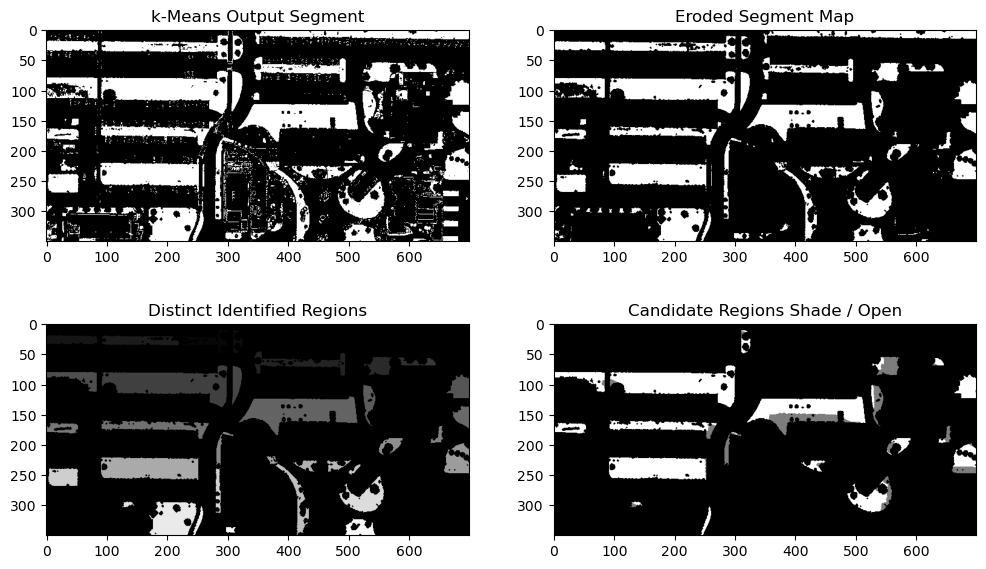

In [41]:
example_segment = segments[100,200]     # obtain segment label associated with one grass pixel for example plots

kernel_size = 3
minimum_area_in_pixels = 85             # note : 1px == 1 sq meter for this data set

eroded_segment_image = erode_segmented_image(segments==example_segment, ndsm_mask, kernel_size)
distinct_regions = distinct_segment_regions( eroded_segment_image, minimum_area_in_pixels )     

plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(segments==example_segment, cmap='gray')
plt.title('k-Means Output Segment')

plt.subplot(222)
plt.imshow(eroded_segment_image, cmap='gray')
plt.title('Eroded Segment Map')

plt.subplot(223)
plt.imshow(distinct_regions, cmap='gray')
plt.title('Distinct Identified Regions')

patches_in_shade, patches_not_in_shade = split_regions_by_shadow(distinct_regions, shadow)
split_patches = np.zeros_like(distinct_regions)
for patch in patches_in_shade:
    for pixel in patches_in_shade[patch]:
         split_patches[pixel] = 125
for patch in patches_not_in_shade:
    for pixel in patches_not_in_shade[patch]:
        split_patches[pixel] = 255

plt.subplot(224)
plt.imshow(split_patches, cmap='gray')
plt.title('Candidate Regions Shade / Open')

plt.show()

#### Full Output ####

The process illustrated in the plot above will be repeated for each segment found in the initial clustering step. The final results, a collection of labeled pixels representing similar surface types in shade and the open, will be exported as a dictionary for use in subsequent processing notebooks.

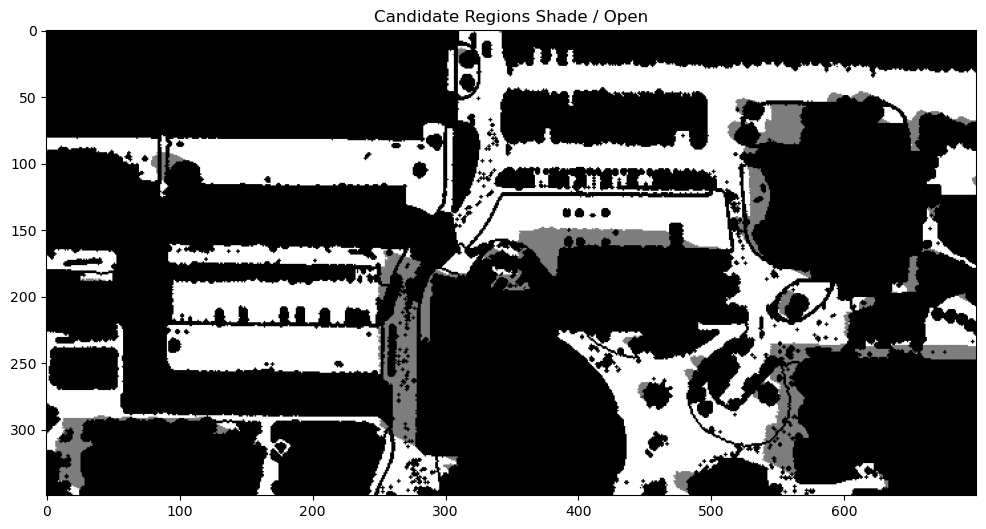

In [42]:
import json

segmentation_results = {}
current_label = 1

for segment in np.unique(segments):
        
    eroded_segment_image = erode_segmented_image(segments==segment, ndsm_mask, kernel_size)
    distinct_regions = distinct_segment_regions( eroded_segment_image, minimum_area_in_pixels )
    patches_in_shade, patches_not_in_shade = split_regions_by_shadow(distinct_regions, shadow)

    for region_id in patches_in_shade:
        segmentation_results[current_label] = {}
        segmentation_results[current_label]['shade'] = patches_in_shade[region_id]
        segmentation_results[current_label]['open'] = patches_not_in_shade[region_id]
        current_label += 1

with open('data/lidar_segmentation.json', 'w') as out_file:
    json.dump(segmentation_results, out_file)

final_map = np.zeros(shape=segments.shape, dtype=np.uint8)    
for region_id in segmentation_results:
    for pixel in segmentation_results[region_id]['shade']:
        final_map[pixel] = 125
    for pixel in segmentation_results[region_id]['open']:
        final_map[pixel] = 255


plt.figure(figsize=(12,12))
plt.imshow(final_map, cmap='gray')
plt.title('Candidate Regions Shade / Open')
plt.show()